In [16]:
import paddle
print(paddle.__version__)
import matplotlib.pyplot as plt
import paddle.vision.transforms as T
import paddle.nn.functional as F

transform = T.Compose([T.Normalize(mean=[127.5],
                                   std=[127.5],
                                   data_format='CHW')])

# 对数据进行归一化
train_dataset = paddle.vision.datasets.FashionMNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.FashionMNIST(mode='test', transform=transform)


2.1.2


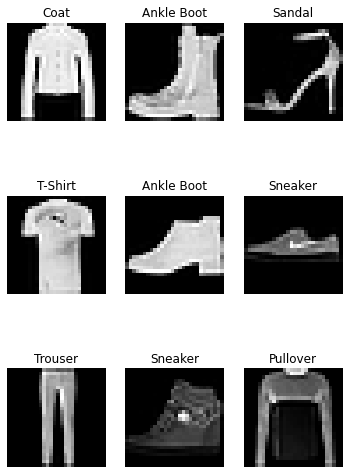

In [2]:
# 随机选取十个训练集数据可视化
label_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(6, 9))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = paddle.randint(len(train_dataset), shape=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[label[0]])
    plt.axis('off')
    # numpy.squeeze 删除长度为1的轴 (1, 28, 28) =>(28, 28)
    plt.imshow(img.squeeze(), cmap='gray')


plt.show()

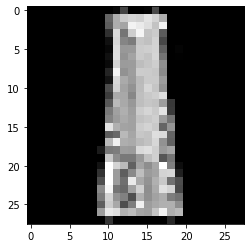

Label: Dress


In [3]:
# 随机选取一个测试数据进行可视化
sample_idx = paddle.randint(len(test_dataset), shape=(1,)).item()
img, label = test_dataset[sample_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.show()
print(f"Label: {label_map[label.item()]}")

In [19]:
# 先实现LeNet，随后测试LeNet的性能
class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=3, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=256, out_features=120)
        self.linear2 = paddle.nn.Linear(in_features=120, out_features=84)
        self.linear3 = paddle.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        # x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        x = paddle.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

In [20]:
# 模型网络结构可视化
net_cls = LeNet()
paddle.summary(net_cls, (-1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-5       [[1, 1, 28, 28]]      [1, 6, 28, 28]          60       
  MaxPool2D-5     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-6       [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
  MaxPool2D-6    [[1, 16, 10, 10]]      [1, 16, 4, 4]            0       
   Linear-7           [[256]]               [120]             30,840     
   Linear-8           [[120]]                [84]             10,164     
   Linear-9            [[84]]                [10]               850      
Total params: 44,330
Trainable params: 44,330
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.17
Estimated Total Size (MB): 0.23
-----------------------------------------------------------------------

{'total_params': 44330, 'trainable_params': 44330}

In [13]:
# 用Model封装模型
model = paddle.Model(net_cls)

# 参数
lr = 0.001
epoch = 50
batch_size = 64
log_dir = 'log/train' # 训练过程中的loss变化log保存路径
save_dir = 'output/model' # 模型保存路径

# 损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
# 优化函数
optimizer = paddle.optimizer.SGD(learning_rate=lr, parameters=model.parameters())

# 配置模型
model.prepare(optimizer, loss_fn, paddle.metric.Accuracy())

#利用visualdl可视化，然后训练并保存模型
callback = paddle.callbacks.VisualDL(log_dir=log_dir)

In [14]:
model.fit(train_dataset, test_dataset, epochs=epoch, batch_size=batch_size, log_freq=1000, save_dir=save_dir ,callbacks=callback)
model.evaluate()

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/50


ValueError: (InvalidArgument) Input X's width should be equal to the Y's height, but received X's shape: [64, 256], Y's shape: [400, 120].
  [Hint: Expected mat_dim_x.width_ == mat_dim_y.height_, but received mat_dim_x.width_:256 != mat_dim_y.height_:400.] (at /home/Paddle/paddle/fluid/operators/matmul_op.cc:594)
  [operator < matmul > error]